In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, \
    ReduceLROnPlateau, TensorBoard



In [2]:
MODEL_DIR = '../modelschest'
LOG_DIR = '../logs/chest/01b/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
if not os.path.exists(LOG_DIR):
    os.mkdir(LOG_DIR)

caminho_bases = os.path.join('..', 'bases', 'chest_xray')
caminho_train = os.path.join(caminho_bases, 'train')
caminho_test = os.path.join(caminho_bases, 'test')
SIZE = (224, 224)

# Callbacks

In [ ]:
tensorboard_logs = TensorBoard(log_dir=LOG_DIR, histogram_freq=1,
                               write_graph=False, write_images=False,
                               update_freq='epoch')
mcp_save = ModelCheckpoint(os.path.join(MODEL_DIR, 
                                        '01b-chest-modelweights.{epoch:02d}-{val_loss:.2f}.hdf5'),
                           save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=0, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4,
                              verbose=1, min_delta=1e-2, mode='min')


# Model

In [3]:
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3, 3),
                         padding='same',
                         activation='relu',
                         input_shape=(*SIZE, 3)),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(32, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.2),
  Conv2D(64, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(256, (3, 3), activation='relu'),
  Flatten(),
  Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
  Dropout(0.4),
  Dense(1, activation='sigmoid')
 
])

model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

# Training and validation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    horizontal_flip=True,
)
train_generator = train_datagen.flow_from_directory(
    caminho_train,
    target_size=SIZE,
    batch_size=64,
    class_mode='binary'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    # brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    horizontal_flip=True,
)

validation_generator = validation_datagen.flow_from_directory(
    caminho_test,
    target_size=SIZE,
    batch_size=32,
    class_mode='binary'
)

In [6]:
epoch = 48
val_loss = 0.42
model.load_weights(
    os.path.join(MODEL_DIR,
                 '01b-chest-modelweights.{:02d}-{:.2f}.hdf5'.format(epoch, val_loss)
                ))


In [13]:
history = model.fit_generator(train_generator,
                              initial_epoch=epoch,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop, mcp_save, reduce_lr, tensorboard_logs],
                              validation_data=validation_generator)


Epoch 31/50
82/82 [==============================] - 169s 2s/step - loss: 0.2342 - acc: 0.9379 - val_loss: 0.4505 - val_acc: 0.8301
Epoch 32/50
82/82 [==============================] - 133s 2s/step - loss: 0.2353 - acc: 0.9377 - val_loss: 0.4461 - val_acc: 0.8301
Epoch 33/50
82/82 [==============================] - 130s 2s/step - loss: 0.2293 - acc: 0.9385 - val_loss: 0.4443 - val_acc: 0.8365
Epoch 34/50
82/82 [==============================] - 133s 2s/step - loss: 0.2330 - acc: 0.9360 - val_loss: 0.4303 - val_acc: 0.8397
Epoch 35/50
82/82 [==============================] - 136s 2s/step - loss: 0.2333 - acc: 0.9348 - val_loss: 0.4763 - val_acc: 0.8157
Epoch 36/50
82/82 [==============================] - 128s 2s/step - loss: 0.2284 - acc: 0.9400 - val_loss: 0.4692 - val_acc: 0.8141
Epoch 37/50
82/82 [==============================] - 137s 2s/step - loss: 0.2297 - acc: 0.9392 - val_loss: 0.4634 - val_acc: 0.8189
Epoch 38/50
81/82 [============================>.] - ETA: 1s - loss: 0.2282 

# Treinar novamente com lr maior

In [7]:
model.compile(optimizer=Adam(lr=0.0004), loss='binary_crossentropy', metrics=['acc'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                              verbose=1, min_delta=0.1, mode='min')

history = model.fit_generator(train_generator,
                              initial_epoch=0,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop, mcp_save, reduce_lr, tensorboard_logs],
                              validation_data=validation_generator)


Epoch 1/50


W0704 15:03:59.673480 140529550505728 deprecation.py:323] From /home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


82/82 [==============================] - 138s 2s/step - loss: 1.2333 - acc: 0.9160 - val_loss: 1.0227 - val_acc: 0.8301
Epoch 2/50
82/82 [==============================] - 140s 2s/step - loss: 0.7998 - acc: 0.9279 - val_loss: 0.9461 - val_acc: 0.8686
Epoch 3/50
81/82 [============================>.] - ETA: 1s - loss: 0.7703 - acc: 0.9315
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.
82/82 [==============================] - 129s 2s/step - loss: 0.7716 - acc: 0.9310 - val_loss: 0.9788 - val_acc: 0.8510
Epoch 4/50
82/82 [==============================] - 131s 2s/step - loss: 0.4906 - acc: 0.9423 - val_loss: 0.7029 - val_acc: 0.8189
Epoch 5/50
82/82 [==============================] - 137s 2s/step - loss: 0.4537 - acc: 0.9411 - val_loss: 0.7324 - val_acc: 0.8093
Epoch 6/50
81/82 [============================>.] - ETA: 1s - loss: 0.4527 - acc: 0.9439
Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
82/82 [=====================

# Carregar melhor modelo

In [4]:
epoch = 14
val_loss = 0.41
model.load_weights(
    os.path.join(MODEL_DIR,
                 '01b-chest-modelweights.{:02d}-{:.2f}.hdf5'.format(epoch, val_loss)
                ))

In [10]:
import numpy as np
import time
from utils import get_imagens_erro, report, plot_errors

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    caminho_test,
    target_size=SIZE,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)
s = len(validation_generator) * 32
t0 = time.time()
y_test, y_pred, X_names_test, y_pred_proba = get_imagens_erro(validation_generator, model)
elapsed = time.time() - t0
print('%d imagens processadas em %s segundos (%s por imagem)' % (s, elapsed, elapsed / s))

Found 624 images belonging to 2 classes.
640 imagens processadas em 8.396369695663452 segundos (0.013119327649474145 por imagem)


In [11]:
report(validation_generator, y_test, y_pred)

{0: 'NORMAL', 1: 'PNEUMONIA'}
R/P 	 NORMAL 	 PNEUMONIA 
NORMAL 	 156 	 78
PNEUMONIA 	 18 	 372
              precision    recall  f1-score   support

         0.0       0.90      0.67      0.76       234
         1.0       0.83      0.95      0.89       390

    accuracy                           0.85       624
   macro avg       0.86      0.81      0.83       624
weighted avg       0.85      0.85      0.84       624



In [12]:
print('accuracy: %s' % (sum(np.array(y_test) == np.array(y_pred)) / len(y_test)))

accuracy: 0.8461538461538461


{0: 'NORMAL', 1: 'PNEUMONIA'}


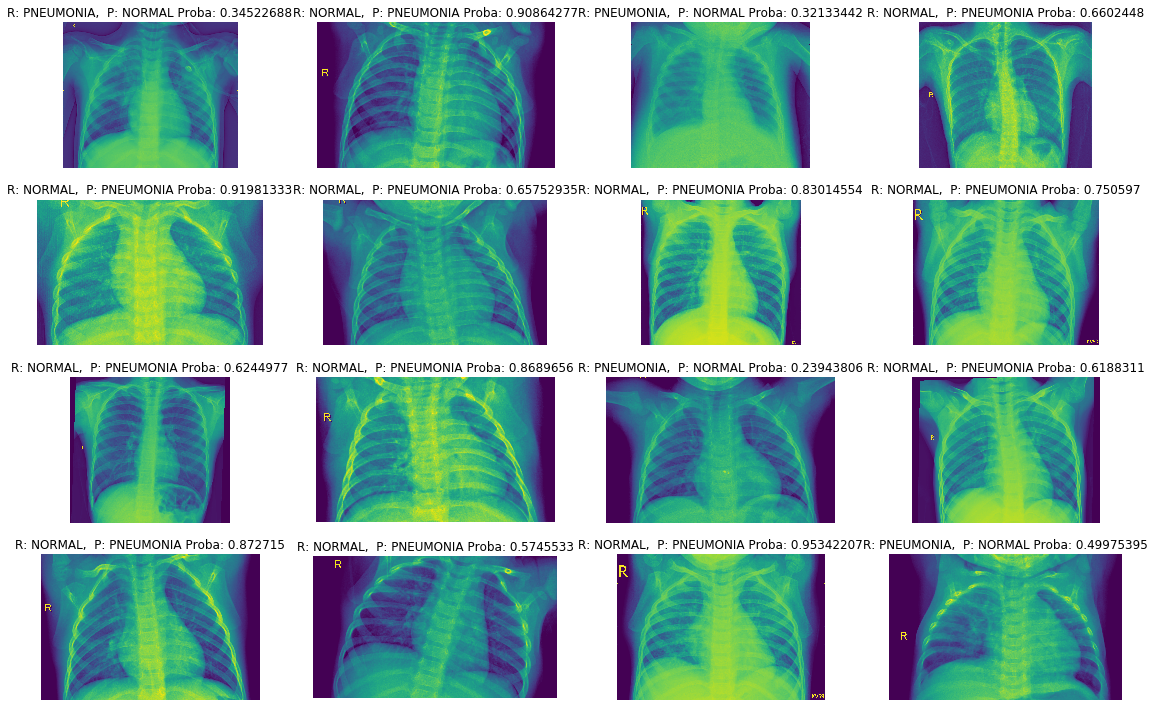

In [13]:
plot_errors(validation_generator, y_test, y_pred, caminho_test, X_names_test, y_pred_proba)

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    caminho_train,
    target_size=SIZE,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)
s = len(train_generator) * 32
t0 = time.time()
y_train, y_pred_train, X_names, y_pred_train_proba = get_imagens_erro(train_generator, model)
elapsed = time.time() - t0
print('%d imagens processadas em %s segundos (%s por imagem)' % (s, elapsed, elapsed / s))

Found 5216 images belonging to 2 classes.
5216 imagens processadas em 86.94358730316162 segundos (0.01666863253511534 por imagem)


In [17]:
report(train_generator, y_train, y_pred_train)

{0: 'NORMAL', 1: 'PNEUMONIA'}
R/P 	 NORMAL 	 PNEUMONIA 
NORMAL 	 1320 	 21
PNEUMONIA 	 249 	 3626
              precision    recall  f1-score   support

         0.0       0.84      0.98      0.91      1341
         1.0       0.99      0.94      0.96      3875

    accuracy                           0.95      5216
   macro avg       0.92      0.96      0.94      5216
weighted avg       0.95      0.95      0.95      5216



In [18]:
print('accuracy: %s' % (sum(np.array(y_train) == np.array(y_pred_train)) / len(y_train)))

accuracy: 0.9482361963190185


{0: 'NORMAL', 1: 'PNEUMONIA'}


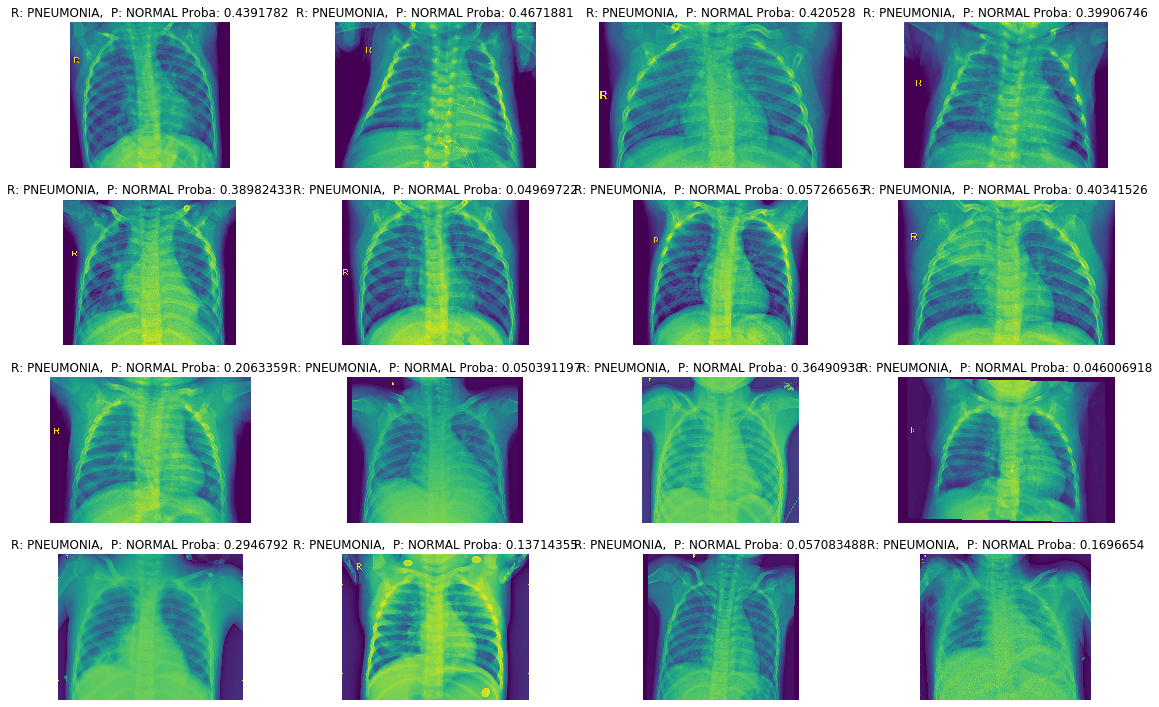

In [19]:
plot_errors(train_generator, y_train, y_pred_train, caminho_train, X_names, y_pred_train_proba)